# Global parameter

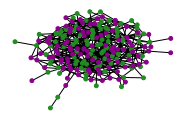

In [56]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import code_two_states.generation_sequences as ge 
import code_two_states.inference_partners as inf
import code_two_states.utility_plot as ut_plot
import code_two_states.loop_function as lp
import code_two_states.mutual_info as mu
import matplotlib.lines as mlines

########## ASPECT #################
width = "article"
width_pt = 430.00462

cmaps_sns = sns.color_palette("colorblind", 10)
l_AF = [0, 3, 2, 8, 1, 4, 5, 6, 7, 9]
cmaps = []
for i in l_AF:
    cmaps.append(cmaps_sns[i])
sns.set_theme(context='notebook', style='ticks', palette=cmaps, color_codes=True, rc=None)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "arial",
    # Use 10pt font in plots, to maT_ch 10pt font in document
    "font.size": 10,
    "axes.titlesize" : 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "axes.labelsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "lines.linewidth" : 1.3,
    'axes.linewidth' : 1,
}

plt.rcParams.update(tex_fonts)
########## ASPECT #################


n_generations = 10 # 2^10 = 1024 chain of spin
n_mutations_branch = 15
n_mutations_branch_2 = 30
n_seq = int(2**n_generations)

n_avg_permut_train_test = 20 # Number of different split in training and testing set for each MSA
n_avg_sampling = 20 ## Number of msa genereted for each couple of parameters

Ta = 2.0
Tb = 5.0

s_train = 400
theta = 0.0
pseudo_count = 0.5
pseudo_count_MI = 0.01
n_pair_species = 4

d_param = {
    "reg" : pseudo_count,
    "n_pair" : n_pair_species,
    "theta" : theta,
    "fast" : False,
    "s_train" : s_train,
    "n_mean" : n_avg_permut_train_test,
          }

d_param_MI = {
    "reg" : pseudo_count_MI,
    "n_pair" : n_pair_species,
    "theta" : theta,
    "fast" : False,
    "s_train" :s_train,
    "n_mean" : n_avg_permut_train_test,
            }

label_0 = "Contacts only"
label_1 = "Phylo rand."
label_2 = "Contacts & phylogeny"
label_3 = "Phylogeny only"
label_4 = "Null model"
ylabel = "Correct prediction fraction"

l_letter = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]
l_mu = [n_mutations_branch, n_mutations_branch_2]
def annotate(i, ax=None):
    if ax is None:
        plt.annotate(l_letter[i], xy=(-0.1, 1.1), xycoords='axes fraction')
    else:
        ax.annotate(l_letter[i], xy=(-0.1, 1.1), xycoords='axes fraction')
        
def annotate_all(ax):
    try:
        shape = ax.shape
    except:
        #no shape so no panels
        ax.margins(x=0)
        return None
    if len(ax.shape)==1:
        n = ax.shape[0]
        if n==2:
            for i in range(n):
                ax[i].set_title("%s: $\mu = %s$"%(l_letter[i], l_mu[i]))
                ax[i].margins(x=0)
        else:
            for i in range(n):
                annotate(i, ax=ax[i])
                ax[i].margins(x=0)
    elif len(ax.shape)==2:
        n,k = ax.shape
        for i in range(n):
            for j in range(k):
                annotate(i*n + j, ax=ax[i,j])
                ax[i, j].margins(x=0)

start_new_graph = False
if start_new_graph:
    N = 200 #Number of node in the graph 200 Nicola
    p = 0.02 ##proba two nodes connected 
    Graph = nx.erdos_renyi_graph(N,p)
    nx.write_gexf(Graph,"graphes/Graph_Erdos")

#Graph = nx.read_gexf("graphes/Graph_Erdos", node_type=int)
## Start from same graph as Nicola
m_adj = np.load("graphes/matcontact_andonis.npy")
Graph = nx.convert_matrix.from_numpy_matrix(m_adj)
nx.write_gexf(Graph,"graphes/Graph_Erdos")

figsize = ut_plot.set_size(width,subplots=(1,1),fraction=0.4)
plt.figure(figsize=figsize)
nx.draw_kamada_kawai(Graph,with_labels=False , node_size=15, node_color=["forestgreen" for node in range(len(Graph.nodes())//2)] + ["darkmagenta" for node in range(len(Graph.nodes())//2)])
plt.savefig("figures_two_states/Graph.eps")

# Sampling data

In [10]:
sampling = ge.Sampling_msa_two_states(Graph)

sampling.T = Ta
l_msa_no_phylo_Ta = lp.loop_on_function(n_avg_sampling, sampling.msa_no_phylo,n_seq)
l_msa_binary_tree_equi_Ta = lp.loop_on_function(n_avg_sampling, sampling.msa_binary_tree,n_generations,n_mutations_branch,1)


sampling.T = Tb
l_msa_binary_tree_rand_phylo = lp.loop_on_function(n_avg_sampling, sampling.msa_binary_tree_pure_phylo, n_generations, n_mutations_branch, 0)
l_msa_binary_tree_rand_phylo_mu2 = lp.loop_on_function(n_avg_sampling, sampling.msa_binary_tree_pure_phylo, n_generations, n_mutations_branch_2, 0)

l_msa_no_phylo_Tb = lp.loop_on_function(n_avg_sampling, sampling.msa_no_phylo,n_seq)

l_msa_binary_tree_equi_Tb = lp.loop_on_function(n_avg_sampling, sampling.msa_binary_tree,n_generations,n_mutations_branch,1)
l_msa_binary_tree_equi_Tb_mu2 = lp.loop_on_function(n_avg_sampling, sampling.msa_binary_tree,n_generations,n_mutations_branch_2,1)


Standard Temperature is 1.0
Number of flip to reach equilibrium is 4000


## Impact Number pairs training set

In [4]:
l_size_train = np.unique(np.geomspace(2, int(1.5*2**(n_generations-1)), num=20, dtype=int))

l_binary_tree_rand_phylo = lp.loop_inf_partners({"s_train" : l_size_train}, inf.Inference_Partner, l_msa=l_msa_binary_tree_rand_phylo, **d_param)
l_binary_tree_rand_phylo_mu2 = lp.loop_inf_partners({"s_train" : l_size_train}, inf.Inference_Partner, l_msa=l_msa_binary_tree_rand_phylo_mu2, **d_param)

l_no_phylo_Tb = lp.loop_inf_partners({"s_train" : l_size_train}, inf.Inference_Partner, l_msa=l_msa_no_phylo_Tb, **d_param)

l_binary_tree_equi_Tb = lp.loop_inf_partners({"s_train" : l_size_train}, inf.Inference_Partner, l_msa=l_msa_binary_tree_equi_Tb, **d_param)
l_binary_tree_equi_Tb_mu2 = lp.loop_inf_partners({"s_train" : l_size_train}, inf.Inference_Partner, l_msa=l_msa_binary_tree_equi_Tb_mu2, **d_param)

l_binary_tree_rand_phylo_MI = lp.loop_inf_partners({"s_train" : l_size_train}, mu.Inference_Partner_Mutual_Info, l_msa=l_msa_binary_tree_rand_phylo, **d_param_MI)
l_binary_tree_rand_phylo_mu2_MI = lp.loop_inf_partners({"s_train" : l_size_train}, mu.Inference_Partner_Mutual_Info, l_msa=l_msa_binary_tree_rand_phylo_mu2, **d_param_MI)

l_no_phylo_Tb_MI = lp.loop_inf_partners({"s_train" : l_size_train}, mu.Inference_Partner_Mutual_Info, l_msa=l_msa_no_phylo_Tb, **d_param_MI)

l_binary_tree_equi_Tb_MI = lp.loop_inf_partners({"s_train" : l_size_train}, mu.Inference_Partner_Mutual_Info, l_msa=l_msa_binary_tree_equi_Tb, **d_param_MI)
l_binary_tree_equi_Tb_mu2_MI = lp.loop_inf_partners({"s_train" : l_size_train}, mu.Inference_Partner_Mutual_Info, l_msa=l_msa_binary_tree_equi_Tb_mu2, **d_param_MI)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


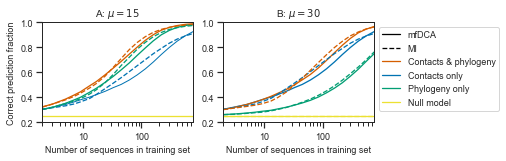

In [5]:
figsize = ut_plot.set_size(width,subplots=(1,2))
fig, ax =  plt.subplots(figsize=figsize, ncols=2)

ax[0].plot(l_size_train,l_no_phylo_Tb, label = label_0, linewidth=1)
ax[0].plot(l_size_train,l_binary_tree_equi_Tb, label = label_2)
ax[0].plot(l_size_train,l_binary_tree_rand_phylo, label = label_3)
ax[0].hlines(1/n_pair_species,l_size_train[0],l_size_train[-1], color = cmaps[3], label = label_4)
ax[0].semilogx()
ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax[1].plot(l_size_train,l_no_phylo_Tb, label = label_0)
ax[1].plot(l_size_train,l_binary_tree_equi_Tb_mu2, label = label_2)
ax[1].plot(l_size_train,l_binary_tree_rand_phylo_mu2, label = label_3)
ax[1].hlines(1/n_pair_species,l_size_train[0],l_size_train[-1], color = cmaps[3], label = label_4)
ax[1].semilogx()
ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


ax[0].plot(l_size_train,l_no_phylo_Tb_MI, label = label_0, ls="--", color=cmaps[0])
ax[0].plot(l_size_train,l_binary_tree_equi_Tb_MI, label = label_2, ls="--", color=cmaps[1])
ax[0].plot(l_size_train,l_binary_tree_rand_phylo_MI, label = label_3, ls="--", color=cmaps[2])

ax[1].plot(l_size_train,l_no_phylo_Tb_MI, label = label_0, ls="--", color=cmaps[0])
ax[1].plot(l_size_train,l_binary_tree_equi_Tb_mu2_MI, label = label_2, ls="--", color=cmaps[1])
ax[1].plot(l_size_train,l_binary_tree_rand_phylo_mu2_MI, label = label_3, ls="--", color=cmaps[2])
ax[1].hlines(1/n_pair_species,l_size_train[0],l_size_train[-1], color = cmaps[3], label = label_4, ls="--")
ax[1].semilogx()
ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

annotate_all(ax)

ax[0].set_ylabel(ylabel)
ax[0].set_xlabel("Number of sequences in training set")
ax[1].set_xlabel("Number of sequences in training set")
ax[0].set_ylim(0.2,1)
ax[1].set_ylim(0.2,1)

Lhandles = []
Lhandles.append(mlines.Line2D([],[],ls = '-', color = "black", label = "mfDCA"))
Lhandles.append(mlines.Line2D([],[],ls = '--',color = "black", label = "MI"))
Lhandles.append( mlines.Line2D([], [], color=cmaps[1], markersize=15, label=label_2))
Lhandles.append( mlines.Line2D([], [], color=cmaps[0], label=label_0 ))
Lhandles.append( mlines.Line2D([], [], color=cmaps[2], markersize=15, label=label_3))
Lhandles.append( mlines.Line2D([], [], color=cmaps[3], markersize=15, label=label_4))
ax[1].legend(bbox_to_anchor=(1, 1),loc='best', handles=Lhandles, markerfirst=True)

#fig.tight_layout()
fig.savefig("figures_two_states/Partners_PairsTrainingSet.eps", format='eps', bbox_inches="tight")
plt.show()

## Impact pseudo_count

In [6]:
l_pseudo_count = np.linspace(0.1,0.9,num=30)

l_no_phylo_reg_Tb = lp.loop_inf_partners({"reg" : l_pseudo_count}, inf.Inference_Partner, l_msa=l_msa_no_phylo_Tb, **d_param)

l_binary_tree_rand_reg_phylo = lp.loop_inf_partners({"reg" : l_pseudo_count}, inf.Inference_Partner, l_msa=l_msa_binary_tree_rand_phylo, **d_param)
l_binary_tree_equi_reg_Tb = lp.loop_inf_partners({"reg" : l_pseudo_count}, inf.Inference_Partner, l_msa=l_msa_binary_tree_equi_Tb, **d_param)

l_binary_tree_rand_reg_phylo_mu2 = lp.loop_inf_partners({"reg" : l_pseudo_count}, inf.Inference_Partner, l_msa=l_msa_binary_tree_rand_phylo_mu2, **d_param)
l_binary_tree_equi_reg_Tb_mu2 = lp.loop_inf_partners({"reg" : l_pseudo_count}, inf.Inference_Partner, l_msa=l_msa_binary_tree_equi_Tb_mu2, **d_param)

##MI##
l_no_phylo_reg_Tb_MI = lp.loop_inf_partners({"reg" : l_pseudo_count}, mu.Inference_Partner_Mutual_Info, l_msa=l_msa_no_phylo_Tb, **d_param_MI)

l_binary_tree_rand_reg_phylo_MI = lp.loop_inf_partners({"reg" : l_pseudo_count}, mu.Inference_Partner_Mutual_Info, l_msa=l_msa_binary_tree_rand_phylo, **d_param_MI)
l_binary_tree_equi_reg_Tb_MI = lp.loop_inf_partners({"reg" : l_pseudo_count}, mu.Inference_Partner_Mutual_Info, l_msa=l_msa_binary_tree_equi_Tb, **d_param_MI)

l_binary_tree_rand_reg_phylo_mu2_MI = lp.loop_inf_partners({"reg" : l_pseudo_count}, mu.Inference_Partner_Mutual_Info, l_msa=l_msa_binary_tree_rand_phylo_mu2, **d_param_MI)
l_binary_tree_equi_reg_Tb_mu2_MI = lp.loop_inf_partners({"reg" : l_pseudo_count}, mu.Inference_Partner_Mutual_Info, l_msa=l_msa_binary_tree_equi_Tb_mu2, **d_param_MI)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


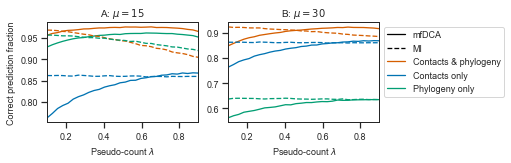

In [7]:
figsize = ut_plot.set_size(width,subplots=(1,2))
fig, ax =  plt.subplots(figsize=figsize, ncols=2)

ax[0].plot(l_pseudo_count, l_no_phylo_reg_Tb, label = label_0)
ax[0].plot(l_pseudo_count,l_binary_tree_equi_reg_Tb, label = label_2)
ax[0].plot(l_pseudo_count,l_binary_tree_rand_reg_phylo, label = label_3)
ax[0].set_xlabel("Pseudo-count $\lambda$")
ax[0].set_ylabel(ylabel)
ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax[1].plot(l_pseudo_count, l_no_phylo_reg_Tb, label = label_0)
ax[1].plot(l_pseudo_count, l_binary_tree_equi_reg_Tb_mu2, label = label_2)
ax[1].plot(l_pseudo_count, l_binary_tree_rand_reg_phylo_mu2, label = label_3)
ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].set_xlabel("Pseudo-count $\lambda$")

##MI##
ax[0].plot(l_pseudo_count, l_no_phylo_reg_Tb_MI, label = label_0, color=cmaps[0], ls="--")
ax[0].plot(l_pseudo_count,l_binary_tree_equi_reg_Tb_MI, label = label_2, color=cmaps[1], ls="--")
ax[0].plot(l_pseudo_count,l_binary_tree_rand_reg_phylo_MI, label = label_3, color=cmaps[2], ls="--")
ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax[1].plot(l_pseudo_count, l_no_phylo_reg_Tb_MI, label = label_0, color=cmaps[0], ls="--")
ax[1].plot(l_pseudo_count, l_binary_tree_equi_reg_Tb_mu2_MI, label = label_2, color=cmaps[1], ls="--")
ax[1].plot(l_pseudo_count, l_binary_tree_rand_reg_phylo_mu2_MI, label = label_3, color=cmaps[2], ls="--")
ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

#ax[0].set_ylim(0.5,1)
#ax[1].set_ylim(0.5,1)

annotate_all(ax)

Lhandles = []
Lhandles.append(mlines.Line2D([],[],ls = '-', color = "black", label = "mfDCA"))
Lhandles.append(mlines.Line2D([],[],ls = '--',color = "black", label = "MI"))
Lhandles.append( mlines.Line2D([], [], color=cmaps[1], markersize=15, label=label_2))
Lhandles.append( mlines.Line2D([], [], color=cmaps[0], label=label_0 ))
Lhandles.append( mlines.Line2D([], [], color=cmaps[2], markersize=15, label=label_3))
#Lhandles.append( mlines.Line2D([], [], color=cmaps[3], markersize=15, label=label_4))
ax[1].legend(bbox_to_anchor=(1, 1),loc='best', handles=Lhandles, markerfirst=True)

#fig.tight_layout()
fig.savefig("figures_two_states/Partners_PseudoCount.eps",bbox_inches = "tight")
plt.show()

## Hist magnetisation

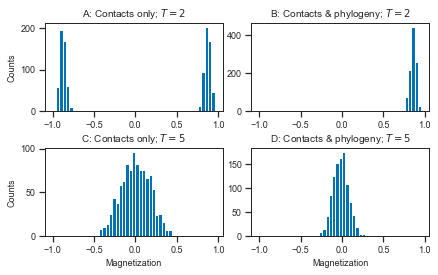

In [8]:
def plot_hist_magnetisation(l_msa, ax, no_mean=False):
    l_hist = []
    if no_mean:
        l_msa = [l_msa[0]]
    for msa in l_msa:
        magn = np.mean(msa, axis=1)
        l_hist.extend(magn)
    bins = np.arange(-1,1,8/msa.shape[1])
    ax.hist(l_hist, bins=bins, range= (-1,1))

figsize = ut_plot.set_size(width,subplots=(2,2),scale_height=1)
fig, ax =  plt.subplots(figsize=figsize, nrows=2, ncols=2)
ax[0,0].set_title("A: %s; $T=2$"%label_0)
ax[0,1].set_title("B: %s; $T=2$"%label_2)
ax[1,0].set_title("C: %s; $T=5$"%label_0)
ax[1,1].set_title("D: %s; $T=5$"%label_2)
ax[1,1].set_xlabel("Magnetization")
ax[1,0].set_xlabel("Magnetization")
ax[0,0].set_ylabel("Counts")
ax[1,0].set_ylabel("Counts")
plot_hist_magnetisation(l_msa_no_phylo_Ta, ax[0,0], no_mean=True)
plot_hist_magnetisation(l_msa_no_phylo_Tb, ax[1,0], no_mean=True)
plot_hist_magnetisation(l_msa_binary_tree_equi_Ta, ax[0,1], no_mean=True)
plot_hist_magnetisation(l_msa_binary_tree_equi_Tb, ax[1,1], no_mean=True)

#annotate_all(ax)

fig.tight_layout(pad=0.2)
fig.savefig("figures_two_states/hist_magnetisation.eps",bbox_inches = "tight")

## Impact number pair species

In [9]:
l_n_pair_species = np.linspace(2,42,num=20,dtype=np.int)

## mfDCA ##
l_binary_tree_rand_pair_phylo = lp.loop_inf_partners({"n_pair" : l_n_pair_species}, inf.Inference_Partner, l_msa=l_msa_binary_tree_rand_phylo, **d_param)
l_binary_tree_rand_pair_phylo_mu2 = lp.loop_inf_partners({"n_pair" : l_n_pair_species}, inf.Inference_Partner, l_msa=l_msa_binary_tree_rand_phylo_mu2, **d_param)

l_no_phylo_pair_Tb = lp.loop_inf_partners({"n_pair" : l_n_pair_species}, inf.Inference_Partner, l_msa=l_msa_no_phylo_Tb, **d_param)

l_binary_tree_equi_pair_Tb = lp.loop_inf_partners({"n_pair" : l_n_pair_species}, inf.Inference_Partner, l_msa=l_msa_binary_tree_equi_Tb, **d_param)
l_binary_tree_equi_pair_Tb_mu2 = lp.loop_inf_partners({"n_pair" : l_n_pair_species}, inf.Inference_Partner, l_msa=l_msa_binary_tree_equi_Tb_mu2, **d_param)

### MI ##
l_binary_tree_rand_pair_phylo_MI = lp.loop_inf_partners({"n_pair" : l_n_pair_species}, mu.Inference_Partner_Mutual_Info, l_msa=l_msa_binary_tree_rand_phylo, **d_param_MI)
l_binary_tree_rand_pair_phylo_mu2_MI = lp.loop_inf_partners({"n_pair" : l_n_pair_species}, mu.Inference_Partner_Mutual_Info, l_msa=l_msa_binary_tree_rand_phylo_mu2, **d_param_MI)

l_no_phylo_pair_Tb_MI = lp.loop_inf_partners({"n_pair" : l_n_pair_species}, mu.Inference_Partner_Mutual_Info, l_msa=l_msa_no_phylo_Tb, **d_param_MI)

l_binary_tree_equi_pair_Tb_MI = lp.loop_inf_partners({"n_pair" : l_n_pair_species}, mu.Inference_Partner_Mutual_Info, l_msa=l_msa_binary_tree_equi_Tb, **d_param_MI)
l_binary_tree_equi_pair_Tb_mu2_MI = lp.loop_inf_partners({"n_pair" : l_n_pair_species}, mu.Inference_Partner_Mutual_Info, l_msa=l_msa_binary_tree_equi_Tb_mu2, **d_param_MI)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


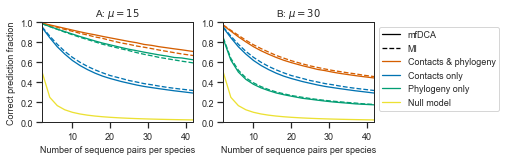

In [10]:
figsize = ut_plot.set_size(width,subplots=(1,2))
fig, ax =  plt.subplots(figsize=figsize, ncols=2)

ax[0].plot(l_n_pair_species,l_no_phylo_pair_Tb, label = label_0)
ax[0].plot(l_n_pair_species,l_binary_tree_equi_pair_Tb, label = label_2)
ax[0].plot(l_n_pair_species,l_binary_tree_rand_pair_phylo, label = label_3)
ax[0].plot(l_n_pair_species, [1/x for x in l_n_pair_species], label = label_4)
ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[0].set_ylim(0,1)

ax[1].plot(l_n_pair_species,l_no_phylo_pair_Tb, label = label_0)
ax[1].plot(l_n_pair_species,l_binary_tree_equi_pair_Tb_mu2, label = label_2)
ax[1].plot(l_n_pair_species,l_binary_tree_rand_pair_phylo_mu2, label = label_3)
ax[1].plot(l_n_pair_species, [1/x for x in l_n_pair_species], label = label_4)
ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].set_ylim(0,1)

## MI ##
ax[0].plot(l_n_pair_species,l_no_phylo_pair_Tb_MI, label = label_0, color=cmaps[0], ls="--")
ax[0].plot(l_n_pair_species,l_binary_tree_equi_pair_Tb_MI, label = label_2, color=cmaps[1], ls="--")
ax[0].plot(l_n_pair_species,l_binary_tree_rand_pair_phylo_MI, label = label_3, color=cmaps[2], ls="--")

ax[1].plot(l_n_pair_species,l_no_phylo_pair_Tb_MI, label = label_0, color=cmaps[0], ls="--")
ax[1].plot(l_n_pair_species,l_binary_tree_equi_pair_Tb_mu2_MI, label = label_2, color=cmaps[1], ls="--")
ax[1].plot(l_n_pair_species,l_binary_tree_rand_pair_phylo_mu2_MI, label = label_3, color=cmaps[2], ls="--")

annotate_all(ax)

ax[0].set_ylabel(ylabel)
ax[0].set_xlabel("Number of sequence pairs per species")
ax[1].set_xlabel("Number of sequence pairs per species")

Lhandles = []
Lhandles.append(mlines.Line2D([],[],ls = '-', color = "black", label = "mfDCA"))
Lhandles.append(mlines.Line2D([],[],ls = '--',color = "black", label = "MI"))
Lhandles.append( mlines.Line2D([], [], color=cmaps[1], markersize=15, label=label_2))
Lhandles.append( mlines.Line2D([], [], color=cmaps[0], label=label_0 ))
Lhandles.append( mlines.Line2D([], [], color=cmaps[2], markersize=15, label=label_3))
Lhandles.append( mlines.Line2D([], [], color=cmaps[3], markersize=15, label=label_4))
ax[1].legend(bbox_to_anchor=(1, 1),loc='best', handles=Lhandles, markerfirst=True)


#fig.tight_layout()
fig.savefig("figures_two_states/Partners_NumberPairsSpecies.eps",bbox_inches = "tight")
plt.show()

# Impact from Sampling 

## Impact number mutations per generation

In [19]:
l_n_mutations_branch = np.linspace(2, 100, num=30, dtype=int)
d_muta = {"n_mutations_branch" : l_n_mutations_branch}
sampling = ge.Sampling_msa_two_states(Graph)
sampling.T = Tb

l_l_msa_binary_tree_rand_phylo = lp.loop_sampling_parameter(n_avg_sampling, d_muta, sampling.msa_binary_tree_pure_phylo, n_generations=n_generations, start_equi=0)
l_msa_no_phylo_Tb = lp.loop_on_function(n_avg_sampling, sampling.msa_no_phylo, n_seq)
l_l_msa_binary_tree_equi_Tb = lp.loop_sampling_parameter(n_avg_sampling, d_muta, sampling.msa_binary_tree, n_generations=n_generations, start_equi=1)

Standard Temperature is 1.0
Number of flip to reach equilibrium is 4000


In [12]:
l_binary_tree_rand_phylo_nmu = lp.loop_inf_partners_data(inf.Inference_Partner, l_l_msa_binary_tree_rand_phylo, **d_param)
no_phylo_Tb_nmu = inf.Inference_Partner(l_msa_no_phylo_Tb, **d_param)
l_binary_tree_equi_mut_Tb_nmu = lp.loop_inf_partners_data(inf.Inference_Partner, l_l_msa_binary_tree_equi_Tb, **d_param)

## MI ##
l_binary_tree_rand_phylo_MI_nmu = lp.loop_inf_partners_data(mu.Inference_Partner_Mutual_Info, l_l_msa_binary_tree_rand_phylo, **d_param_MI)
no_phylo_Tb_MI_nmu = mu.Inference_Partner_Mutual_Info(l_msa_no_phylo_Tb, **d_param_MI)
l_binary_tree_equi_mut_Tb_MI_nmu = lp.loop_inf_partners_data(mu.Inference_Partner_Mutual_Info, l_l_msa_binary_tree_equi_Tb, **d_param_MI)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


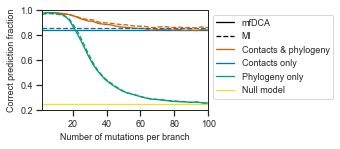

In [13]:
figsize = ut_plot.set_size(width_pt/2,subplots=(1,1))
fig, ax =  plt.subplots(figsize=figsize, ncols=1)

ax.plot(l_n_mutations_branch, [no_phylo_Tb_nmu for i in l_n_mutations_branch], label = label_0)
ax.plot(l_n_mutations_branch, l_binary_tree_equi_mut_Tb_nmu, label = label_2)
ax.plot(l_n_mutations_branch, l_binary_tree_rand_phylo_nmu, label = label_3)

##MI##
ax.plot(l_n_mutations_branch,[no_phylo_Tb_MI_nmu for i in l_n_mutations_branch], label = label_0, color=cmaps[0], ls="--")
ax.plot(l_n_mutations_branch, l_binary_tree_equi_mut_Tb_MI_nmu, label = label_2, color=cmaps[1], ls="--")
ax.plot(l_n_mutations_branch, l_binary_tree_rand_phylo_MI_nmu, label = label_3, color=cmaps[2], ls="--")

ax.hlines(1/n_pair_species,l_n_mutations_branch[0],l_n_mutations_branch[-1], color = cmaps[3], label = label_4)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax.legend(bbox_to_anchor=(1, 1.15))
ax.set_ylim(0.2,1)

ax.set_ylabel(ylabel)
ax.set_xlabel("Number of mutations per branch")
annotate_all(ax)

Lhandles = []
Lhandles.append(mlines.Line2D([],[],ls = '-', color = "black", label = "mfDCA"))
Lhandles.append(mlines.Line2D([],[],ls = '--',color = "black", label = "MI"))
Lhandles.append( mlines.Line2D([], [], color=cmaps[1], markersize=15, label=label_2))
Lhandles.append( mlines.Line2D([], [], color=cmaps[0], label=label_0 ))
Lhandles.append( mlines.Line2D([], [], color=cmaps[2], markersize=15, label=label_3))
Lhandles.append( mlines.Line2D([], [], color=cmaps[3], markersize=15, label=label_4))
ax.legend(bbox_to_anchor=(1, 1),loc='best', handles=Lhandles, markerfirst=True)

#fig.tight_layout()
fig.savefig("figures_two_states/Partners_NumberMutation.eps",bbox_inches = "tight")
plt.show()

### Impact inferrence of Jij

In [20]:
import importlib
importlib.reload(inf)

def Jij_true_from_graph(Graph, T=1):
    n = len(Graph)
    Jij = np.zeros((n,n))
    for i in range(n):
        for j in range(i, n):
            if (i,j) in Graph.edges():
                Jij[i,j] = 1/T
                Jij[j,i] = 1/T
    return Jij

Jij_para = Jij_true_from_graph(Graph, T=Tb)

l_binary_tree_equi_mut_Tb_nmu = lp.loop_inf_partners_data(inf.Inference_Partner, l_l_msa_binary_tree_equi_Tb, **d_param)
l_binary_tree_equi_mut_Tb_nmu_true_coupling = lp.loop_inf_partners_data(inf.Inference_Partner, l_l_msa_binary_tree_equi_Tb, graph=Graph, **d_param)
l_binary_tree_equi_mut_Tb_nmu_true_model = lp.loop_inf_partners_data(inf.Inference_Partner, l_l_msa_binary_tree_equi_Tb, Jij_para=Jij_para, **d_param)
l_binary_tree_equi_mut_Tb_nmu_false_contact = lp.loop_inf_partners_data(inf.Inference_Partner, l_l_msa_binary_tree_equi_Tb, graph=Graph, false_contact=True, **d_param)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


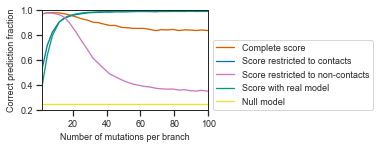

In [21]:
figsize = ut_plot.set_size(width_pt/2,subplots=(1,1))
fig, ax =  plt.subplots(figsize=figsize, ncols=1)

ax.plot(l_n_mutations_branch, l_binary_tree_equi_mut_Tb_nmu_true_coupling)
ax.plot(l_n_mutations_branch, l_binary_tree_equi_mut_Tb_nmu)
ax.plot(l_n_mutations_branch, l_binary_tree_equi_mut_Tb_nmu_true_model)
ax.plot(l_n_mutations_branch, l_binary_tree_equi_mut_Tb_nmu_false_contact, color=cmaps[5])

ax.hlines(1/n_pair_species,l_n_mutations_branch[0],l_n_mutations_branch[-1], color=cmaps[3])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax.legend(bbox_to_anchor=(1, 1.15))
ax.set_ylim(0.2,1)

ax.set_ylabel(ylabel)
ax.set_xlabel("Number of mutations per branch")
annotate_all(ax)

Lhandles = []
#Lhandles.append(mlines.Line2D([],[],ls = '-', color = "black", label = "mfDCA"))
Lhandles.append( mlines.Line2D([], [], color=cmaps[1], markersize=15, label="Complete score"))
Lhandles.append( mlines.Line2D([], [], color=cmaps[0], label="Score restricted to contacts"))
Lhandles.append( mlines.Line2D([], [], color=cmaps[5], label="Score restricted to non-contacts"))
Lhandles.append( mlines.Line2D([], [], color=cmaps[2], markersize=15, label="Score with real model"))
Lhandles.append( mlines.Line2D([], [], color=cmaps[3], markersize=15, label=label_4))
ax.legend(bbox_to_anchor=(1, 0.75), handles=Lhandles, markerfirst=True)

#fig.tight_layout()
fig.savefig("figures_two_states/Fig_4_Partners_NumberMutation_true_contacts.eps",bbox_inches = "tight")
plt.show()

In [60]:
import codes_bmdca.utility_infer_field_bmdca as fbm
import importlib
importlib.reload(fbm)
importlib.reload(inf)

def convert_Jijkl_to_Jij(l_Jij_bmDCA):
    l_Jij = []
    for Jijkl in l_Jij_bmDCA:
        l_Jij.append(np.copy(Jijkl[:,0,:,0]))
    return l_Jij

n_state_spin = 2
l_n_mutations_branch_bmdca = l_n_mutations_branch[0:-1:len(l_n_mutations_branch)//4]
l_msa_binary_tree_equi_Tb_bmdca = np.array(l_l_msa_binary_tree_equi_Tb[0:-1:len(l_n_mutations_branch)//4])[:,0]

if True:
    l_Jijkl_bmDCA, l_msa_test_int = fbm.infer_bmDCA_fields(l_msa_binary_tree_equi_Tb_bmdca, l_n_mutations_branch_bmdca, s_train, force_relearning=True)
    np.save("codes_bmdca/l_Jijkl_bmDCA.npy", l_Jijkl_bmDCA)
    np.save("codes_bmdca/l_msa_test_int.npy", l_msa_test_int)
else:
    l_Jijkl_bmDCA = np.load("codes_bmdca/l_Jijkl_bmDCA.npy")
    l_msa_test_int = np.load("codes_bmdca/l_msa_test_int.npy")
    
l_Jij_bmDCA = convert_Jijkl_to_Jij(l_Jijkl_bmDCA)
l_msa_test = (2*np.array(l_msa_test_int)-1)


l_infered_phylo_bmDCA = [
        inf.Inference_Partner(
            np.array([msa]), s_train, pseudo_count, n_pair_species,
            theta=theta, n_mean=1, graph=None, Jij_para=l_Jij_bmDCA[i],
            false_contact=False, msa_testing_input=l_msa_test[i]
            )
        for i,msa in enumerate(l_msa_binary_tree_equi_Tb_bmdca)
        ]


l_infered_phylo_true_coupling_bmDCA = [
        inf.Inference_Partner(
            np.array([msa]), s_train, pseudo_count, n_pair_species,
            theta=theta, n_mean=1, graph=Graph, Jij_para=l_Jij_bmDCA[i],
            false_contact=False, msa_testing_input=l_msa_test[i]
            )
    for i,msa in enumerate(l_msa_binary_tree_equi_Tb_bmdca)
                                    ]

l_infered_phylo_false_coupling_bmDCA = [
        inf.Inference_Partner(
            np.array([msa]), s_train, pseudo_count, n_pair_species,
            theta=theta, n_mean=1, graph=Graph, Jij_para=l_Jij_bmDCA[i],
            false_contact=True, msa_testing_input=l_msa_test[i]
            )
    for i, msa in enumerate(l_msa_binary_tree_equi_Tb_bmdca)
                                    ]

codes_bmdca/data_modif_tree_mu/msa_2_mutations_400_size_train.fasta


KeyboardInterrupt: 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


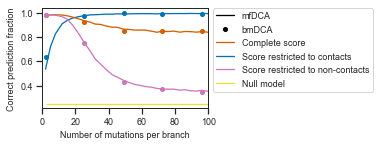

In [61]:
figsize = ut_plot.set_size(width_pt/2,subplots=(1,1))
fig, ax =  plt.subplots(figsize=figsize, ncols=1)
markersize=8
ax.plot(l_n_mutations_branch, l_binary_tree_equi_mut_Tb_nmu_true_coupling)
ax.plot(l_n_mutations_branch, l_binary_tree_equi_mut_Tb_nmu)
#ax.plot(l_n_mutations_branch, l_binary_tree_equi_mut_Tb_nmu_true_model)
ax.plot(l_n_mutations_branch, l_binary_tree_equi_mut_Tb_nmu_false_contact, color=cmaps[5])

ax.plot(l_n_mutations_branch_bmdca, l_infered_phylo_bmDCA, color=cmaps[1], ls="", marker=".", markersize=markersize)
ax.plot(l_n_mutations_branch_bmdca, l_infered_phylo_true_coupling_bmDCA, color=cmaps[0], ls="", marker=".", markersize=markersize)
ax.plot(l_n_mutations_branch_bmdca, l_infered_phylo_false_coupling_bmDCA, color=cmaps[5], ls="", marker=".", markersize=markersize)

ax.hlines(1/n_pair_species,l_n_mutations_branch[0],l_n_mutations_branch[-1], color=cmaps[3])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax.legend(bbox_to_anchor=(1, 1.15))
#ax.set_ylim(0.2,1)

ax.set_ylabel(ylabel)
ax.set_xlabel("Number of mutations per branch")
annotate_all(ax)
ax.set_xlim(xmin=0)

Lhandles = []
Lhandles.append(mlines.Line2D([],[],ls = '-', color = "black", label = "mfDCA"))
Lhandles.append(mlines.Line2D([],[],ls = '', marker= ".", markersize=markersize, color = "black", label = "bmDCA"))
Lhandles.append( mlines.Line2D([], [], color=cmaps[1], markersize=15, label="Complete score"))
Lhandles.append( mlines.Line2D([], [], color=cmaps[0], label="Score restricted to contacts"))
Lhandles.append( mlines.Line2D([], [], color=cmaps[5], label="Score restricted to non-contacts"))
#Lhandles.append( mlines.Line2D([], [], color=cmaps[2], markersize=15, label="Score with real model"))
Lhandles.append( mlines.Line2D([], [], color=cmaps[3], markersize=15, label=label_4))
ax.legend(bbox_to_anchor=(1, 1.05), handles=Lhandles, markerfirst=True)

#fig.tight_layout()
fig.savefig("figures_two_states/Fig_4_Partners_NumberMutation_true_contacts_no_reweight.eps",bbox_inches = "tight")
plt.show()

### Impact données générées avec le modèle inféré

par exemple le modèle inféré sur des données sans phylogénie (mais ensuite avec phylogénie dans la génération puisqu'on fait varier mu)

In [15]:
import codes_bmdca.utility_infer_field_bmdca as fbm
import importlib
import code_two_states.generation_sequence_bmDCA as ge_bmDCA
importlib.reload(fbm)
importlib.reload(inf)
importlib.reload(lp)
Flip_equi = 1000

if False:
    l_path_coupling = fbm.infer_bmDCA_fields([l_msa_no_phylo_Tb[0]], ["no_phylo"], return_path_coupling=True, force_relearning=True)
    path_coupling = l_path_coupling[0]
    np.save("codes_bmdca/path_coupling_no_phylo.npy", path_coupling)
else:
    path_coupling = str(np.load("codes_bmdca/path_coupling_no_phylo.npy"))
    
Field, Coupling = fbm.import_msa_bmDCA(path_coupling)
msa_gen_bmDCA = ge_bmDCA.Creation_MSA_Generation(Field, Coupling)
msa_no_phylo = msa_gen_bmDCA.msa_no_phylo(n_seq, Flip_equi)
    
l_n_mutations_branch = np.linspace(2, 100, num=30, dtype=int)
d_muta = {"n_mutations_generation" : l_n_mutations_branch}
d_args = {
    "n_generations" : n_generations,
    "flip_before_start" : Flip_equi,
    "n_avg_sampling" : n_avg_sampling,
}

l_l_msa_binary_tree_equi_bmDCA = lp.loop_on_function_dict(d_muta, msa_gen_bmDCA.msa_phylo, **d_args)
l_l_msa_binary_tree_equi_bmDCA = l_l_msa_binary_tree_equi_bmDCA*2-1

codes_bmdca/data_modif_tree_mu/msa_no_phylo_mutations_None_size_train.fasta
CompletedProcess(args='bmdca -i codes_bmdca/data_modif_tree_mu/msa_no_phylo_mutations_None_size_train.fasta -c codes_bmdca/bmdca.conf -d codes_bmdca/data_modif_tree_mu/msa_no_phylo_mutations_None_size_train_calcul/ -f', returncode=0, stdout=b'1024 sequences\n200 positions\n2 amino acids (including gaps)\n1024 effective sequences\nloading hyperparameters... done.\ninitializing run... 0.175517 sec\n\nStep: 1\nsampling model with mcmc... 0.286696 sec\nupdating mcmc with samples... 0.174545 sec\ncomputing sequence energies and correlations... 0.0692722 sec\ncomputing mcmc 1p and 2p statistics... 0.139847 sec\ncomputing error and updating gradient... 0.0210352 sec\nupdate learning rate... 0.0039153 sec\nupdating parameters... 0.00232048 sec\n\nStep: 2\nsampling model with mcmc... 0.282288 sec\nupdating mcmc with samples... 0.174879 sec\ncomputing sequence energies and correlations... 0.0692475 sec\ncomputing mcmc 1p

In [16]:
l_binary_tree_equi_mut_Tb_nmu_bmDCA = lp.loop_inf_partners_data(inf.Inference_Partner, l_l_msa_binary_tree_equi_bmDCA, **d_param)
l_binary_tree_equi_mut_Tb_nmu_true_coupling_bmDCA = lp.loop_inf_partners_data(inf.Inference_Partner, l_l_msa_binary_tree_equi_bmDCA, graph=Graph, **d_param)
l_binary_tree_equi_mut_Tb_nmu_false_contact_bmDCA = lp.loop_inf_partners_data(inf.Inference_Partner, l_l_msa_binary_tree_equi_bmDCA, graph=Graph, false_contact=True, **d_param)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


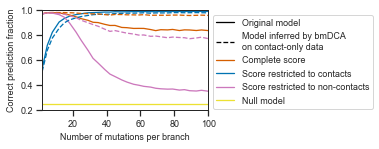

In [30]:
figsize = ut_plot.set_size(width_pt/2,subplots=(1,1))
fig, ax =  plt.subplots(figsize=figsize, ncols=1)

ax.plot(l_n_mutations_branch, l_binary_tree_equi_mut_Tb_nmu_true_coupling)
ax.plot(l_n_mutations_branch, l_binary_tree_equi_mut_Tb_nmu)
ax.plot(l_n_mutations_branch, l_binary_tree_equi_mut_Tb_nmu_false_contact, color=cmaps[5])


ax.plot(l_n_mutations_branch, l_binary_tree_equi_mut_Tb_nmu_true_coupling_bmDCA, color=cmaps[0], ls="--")
ax.plot(l_n_mutations_branch, l_binary_tree_equi_mut_Tb_nmu_bmDCA, color=cmaps[1], ls="--")
ax.plot(l_n_mutations_branch, l_binary_tree_equi_mut_Tb_nmu_false_contact_bmDCA, color=cmaps[5], ls="--")

ax.hlines(1/n_pair_species,l_n_mutations_branch[0],l_n_mutations_branch[-1], color=cmaps[3])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax.legend(bbox_to_anchor=(1, 1.15))
ax.set_ylim(0.2,1)

ax.set_ylabel(ylabel)
ax.set_xlabel("Number of mutations per branch")
annotate_all(ax)

Lhandles = []
Lhandles.append(mlines.Line2D([],[],ls = '-', color = "black", label = "Original model"))
Lhandles.append(mlines.Line2D([],[],ls = '--', color = "black", label = "Model inferred by bmDCA\non contact-only data"))
Lhandles.append( mlines.Line2D([], [], color=cmaps[1], markersize=15, label="Complete score"))
Lhandles.append( mlines.Line2D([], [], color=cmaps[0], label="Score restricted to contacts"))
Lhandles.append( mlines.Line2D([], [], color=cmaps[5], label="Score restricted to non-contacts"))
#Lhandles.append( mlines.Line2D([], [], color=cmaps[2], markersize=15, label="Score with real model"))
Lhandles.append( mlines.Line2D([], [], color=cmaps[3], markersize=15, label=label_4))
ax.legend(bbox_to_anchor=(1, 1), handles=Lhandles, markerfirst=True)

#fig.tight_layout()
fig.savefig("figures_two_states/Fig_4_Partners_NumberMutation_true_contacts_bmDCA_inference_generated.eps",bbox_inches = "tight")
plt.show()

## Impact temperature

In [53]:
l_temp = np.linspace(1,10,num=30,dtype=np.float32)
sampling = ge.Sampling_msa_two_states(Graph)

l_l_msa_no_phylo_temp = lp.loop_sampling_temperature(n_avg_sampling, l_temp,sampling, sampling.msa_no_phylo, n_seq)
l_l_msa_binary_tree_equi_temp = lp.loop_sampling_temperature(n_avg_sampling,l_temp,sampling,sampling.msa_binary_tree,n_generations,n_mutations_branch,1)
l_l_msa_binary_tree_equi_temp2 = lp.loop_sampling_temperature(n_avg_sampling,l_temp,sampling,sampling.msa_binary_tree,n_generations,n_mutations_branch_2,1)

l_msa_binary_tree_rand_phylo = lp.loop_on_function(n_avg_sampling,sampling.msa_binary_tree_pure_phylo,n_generations,n_mutations_branch,0)
l_msa_binary_tree_rand_phylo2 = lp.loop_on_function(n_avg_sampling,sampling.msa_binary_tree_pure_phylo,n_generations,n_mutations_branch_2,0)

Standard Temperature is 1.0
Number of flip to reach equilibrium is 4000


In [54]:
l_no_phylo_temp = lp.loop_inf_partners_data(inf.Inference_Partner, l_l_msa_no_phylo_temp, **d_param)
l_binary_tree_equi_temp = lp.loop_inf_partners_data(inf.Inference_Partner, l_l_msa_binary_tree_equi_temp, **d_param)
l_binary_tree_equi_temp2 = lp.loop_inf_partners_data(inf.Inference_Partner, l_l_msa_binary_tree_equi_temp2, **d_param)
pure_phylo_result = inf.Inference_Partner(l_msa_binary_tree_rand_phylo, **d_param)
pure_phylo_result2 = inf.Inference_Partner(l_msa_binary_tree_rand_phylo2, **d_param)

##MI##
l_no_phylo_temp_MI = lp.loop_inf_partners_data(mu.Inference_Partner_Mutual_Info, l_l_msa_no_phylo_temp, **d_param_MI)
l_binary_tree_equi_temp_MI = lp.loop_inf_partners_data(mu.Inference_Partner_Mutual_Info, l_l_msa_binary_tree_equi_temp, **d_param_MI)
l_binary_tree_equi_temp2_MI = lp.loop_inf_partners_data(mu.Inference_Partner_Mutual_Info, l_l_msa_binary_tree_equi_temp2, **d_param_MI)
pure_phylo_result_MI = mu.Inference_Partner_Mutual_Info(l_msa_binary_tree_rand_phylo, **d_param_MI)
pure_phylo_result2_MI = mu.Inference_Partner_Mutual_Info(l_msa_binary_tree_rand_phylo2, **d_param_MI)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


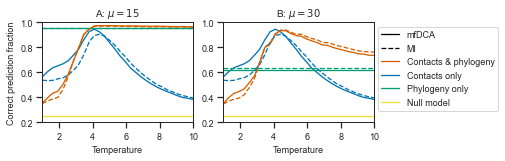

In [55]:
figsize = ut_plot.set_size(width, subplots=(1,2))
fig, ax = plt.subplots(figsize=figsize, ncols=2)
ax[0].plot(l_temp,l_no_phylo_temp, label=label_0)
ax[0].plot(l_temp,l_binary_tree_equi_temp, label=label_2)
ax[0].plot(l_temp,[pure_phylo_result for i in l_temp], label=label_3)
ax[0].plot(l_temp,[1/n_pair_species for i in l_temp], label=label_4)
ax[0].set_ylabel(ylabel)
ax[0].set_xlabel("Temperature")

ax[1].plot(l_temp,l_no_phylo_temp, label=label_0)
ax[1].plot(l_temp,l_binary_tree_equi_temp2, label=label_2)
ax[1].plot(l_temp,[pure_phylo_result2 for i in l_temp], label=label_3)
ax[1].plot(l_temp,[1/n_pair_species for i in l_temp], label=label_4)
ax[1].set_xlabel("Temperature")

##MI##
ax[0].plot(l_temp,l_no_phylo_temp_MI, label=label_0, ls="--", color=cmaps[0])
ax[0].plot(l_temp,l_binary_tree_equi_temp_MI, label=label_2, ls="--", color=cmaps[1])
ax[0].plot(l_temp,[pure_phylo_result_MI for i in l_temp], label=label_3, ls="--", color=cmaps[2])

ax[1].plot(l_temp,l_no_phylo_temp_MI, label=label_0, ls="--", color=cmaps[0])
ax[1].plot(l_temp,l_binary_tree_equi_temp2_MI, label=label_2, ls="--", color=cmaps[1])
ax[1].plot(l_temp,[pure_phylo_result2_MI for i in l_temp], label=label_3, ls="--", color=cmaps[2])

ax[0].set_ylim(0.2,1)
ax[1].set_ylim(0.2,1)
annotate_all(ax)

Lhandles = []
Lhandles.append(mlines.Line2D([],[],ls = '-', color = "black", label = "mfDCA"))
Lhandles.append(mlines.Line2D([],[],ls = '--',color = "black", label = "MI"))
Lhandles.append( mlines.Line2D([], [], color=cmaps[1], markersize=15, label=label_2))
Lhandles.append( mlines.Line2D([], [], color=cmaps[0], label=label_0 ))
Lhandles.append( mlines.Line2D([], [], color=cmaps[2], markersize=15, label=label_3))
Lhandles.append( mlines.Line2D([], [], color=cmaps[3], markersize=15, label=label_4))
ax[1].legend(bbox_to_anchor=(1.85,1),loc='upper right', handles=Lhandles, markerfirst=True)

#fig.tight_layout()

#ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
fig.savefig("figures_two_states/Partners_temperature.eps",bbox_inches = "tight")

In [49]:
msa1 = np.ones((1000,200))
msa2 = -1*np.ones((1000,200))
msa = np.append(msa1, msa2, axis=0)
inf.Inference_Partner(np.array([msa], dtype=np.int8), s_train=400, reg=0.5, n_pair=8)

0.2525963149078727